# Permutation Importance

Introduction

One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions?

This concept is called feature importance.


There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.

In this lesson, we'll focus on permutation importance. Compared to most other approaches, permutation importance is:


fast to calculate,

widely used and understood, and

consistent with properties we would want a feature importance measure to have.

Permutation importance is calculated after a model has been fitted.
So we won't change the model or change what predictions

Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions.

With this insight, the process is as follows:


Get a trained model.


Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.


Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Interpreting Permutation Importances



The values towards the top are the most important features, and those towards the bottom matter least.


The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).


Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.


You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate.

# Partial Plots

#### Partial Dependence Plots


While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

If you are familiar with linear or logistic regression models, partial dependence plots can be interpreted similarly to the coefficients in those models. Though, partial dependence plots on sophisticated models can capture more complex patterns than coefficients from simple models.

How it Works

Like permutation importance, partial dependence plots are calculated after a model has been fit. The model is fit on real data that has not been artificially manipulated in any way.

In [ ]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

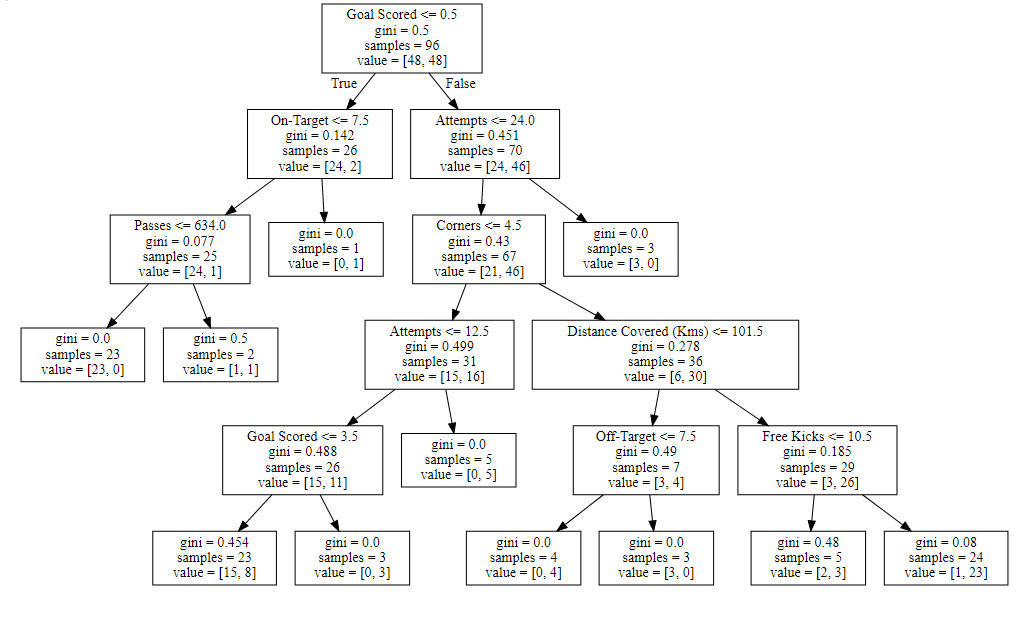

In [ ]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

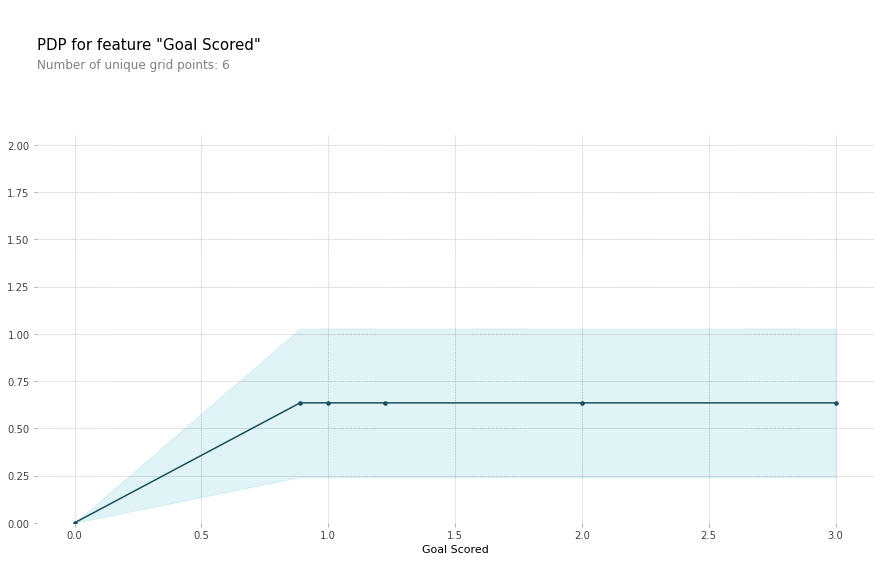

A few items are worth pointing out as you interpret this plot



The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
A blue shaded area indicates level of confidence

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match." But extra goals beyond that appear to have little impact on predictions.

2D Partial Dependence Plots

If you are curious about interactions between features, 2D partial dependence plots are also useful. An example may clarify this.

In [ ]:
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1  =  pdp.pdp_interact(model=tree_model, dataset=val_X, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

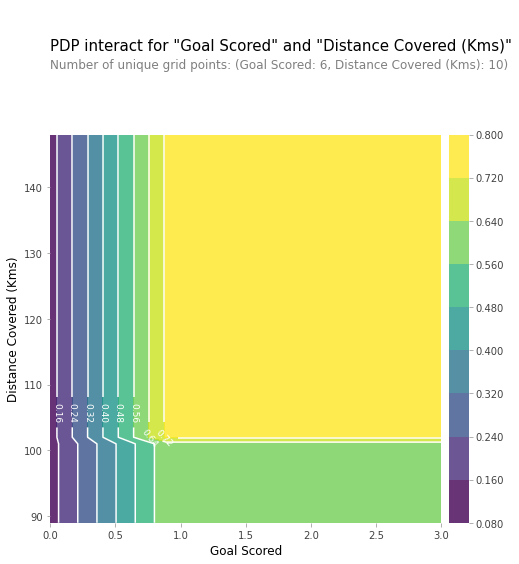

This graph shows predictions for any combination of Goals Scored and Distance covered.

For example, we see the highest predictions when a team scores at least 1 goal and they run a total distance close to 100km. If they score 0 goals, distance covered doesn't matter. Can you see this by tracing through the decision tree with 0 goals?

But distance can impact predictions if they score goals. Make sure you can see this from the 2D partial dependence plot. Can you see this pattern in the decision tree too?

# SHAP Values

Introduction


You've seen (and used) techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Where could you use this?

A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions
You'll use SHAP Values to explain individual predictions in this lesson. In the next lesson, you'll see how these can be aggregated into powerful model-level insights.



How They Work


SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

we predicted whether a team would have a player win the Man of the Match award.

We could ask:

How much was a prediction driven by the fact that the team scored 3 goals?
But it's easier to give a concrete, numeric answer if we restate this as:

How much was a prediction driven by the fact that the team scored 3 goals, instead of some baseline number of goals.
Of course, each team has many features. So if we answer this question for number of goals, we could repeat the process for all other features.

SHAP values do this in a way that guarantees a nice property. Specifically, you decompose a prediction with the following equation:

sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values

That is, the SHAP values of all features sum up to explain why my prediction was different from the baseline. This allows us to decompose a prediction in a graph like this:

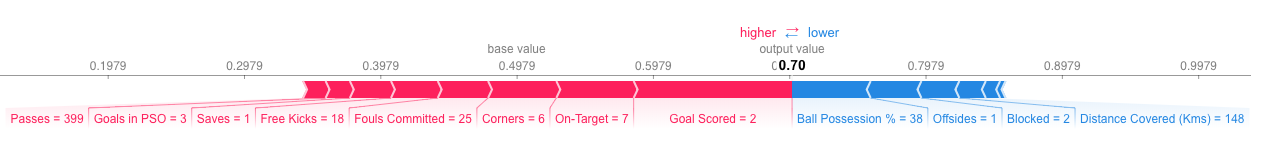

How do you interpret this?

We predicted 0.7, whereas the base_value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from Goal Scored being 2. Though the ball possession value has a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

There is some complexity to the technique, to ensure that the baseline plus the sum of individual effects adds up to the prediction (which isn't as straightforward as it sounds).

for more details
https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d 

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

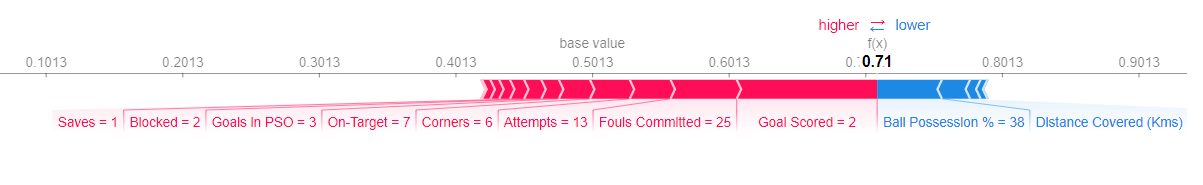

In [ ]:
# use Kernel SHAP to explain test set predictions

k_explainer = shap.KernelExplainer(my_model.predict_proba, train_X)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

# Advanced Uses of SHAP Values

Shap values allow us to decompose any prediction into the sum of effects of each feature value, yielding a graph like this:
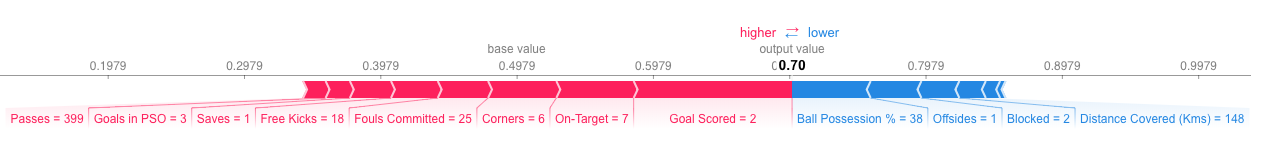

https://i.imgur.com/JVD2U7k.png

Summary Plots


Permutation importance is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has

a large effect for a few predictions, but no effect in general, or
a medium effect for all predictions.
SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 

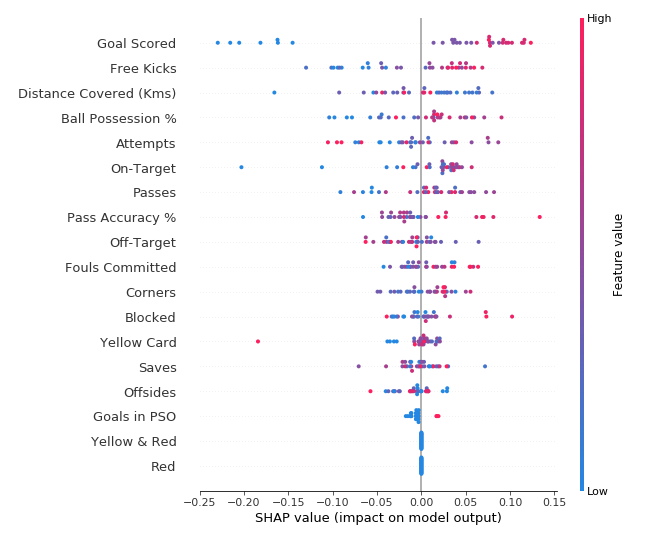

This plot is made of many dots. Each dot has three characteristics:


Vertical location shows what feature it is depicting

Color shows whether that feature was high or low for that row of the dataset

Horizontal location shows whether the effect of that value caused a higher or lower prediction.

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)


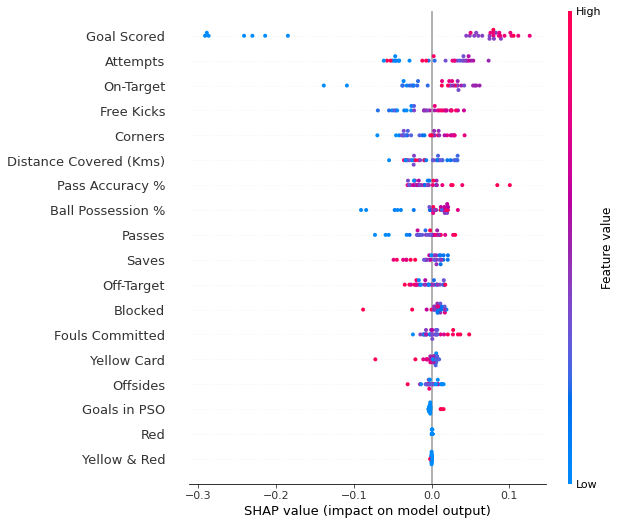

The code isn't too complex. But there are a few caveats.


When plotting, we call shap_values[1]. For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, we index in to get the SHAP values for the prediction of "True".

Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small. But you'll want to be careful when running these to plot with reasonably sized datasets. The exception is when using an xgboost model, which SHAP has some optimizations for and which is thus much faster.


This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play.

### SHAP Dependence Contribution Plots
We've previously used Partial Dependence Plots to show how a single feature impacts predictions. These are insightful and relevant for many real-world use cases. Plus, with a little effort, they can be explained to a non-technical audience.

But there's a lot they don't show. For instance, what is the distribution of effects? Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

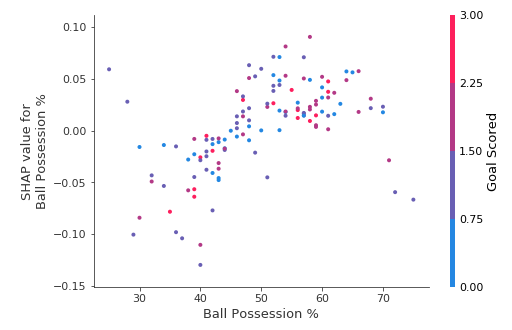

Start by focusing on the shape, and we'll come back to color in a minute. Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact this slopes upward says that the more you possess the ball, the higher the model's prediction is for winning the Man of the Match award.

The spread suggests that other features must interact with Ball Possession %. For example, here we have highlighted two points with similar ball possession values. That value caused one prediction to increase, and it caused the other prediction to decrease.

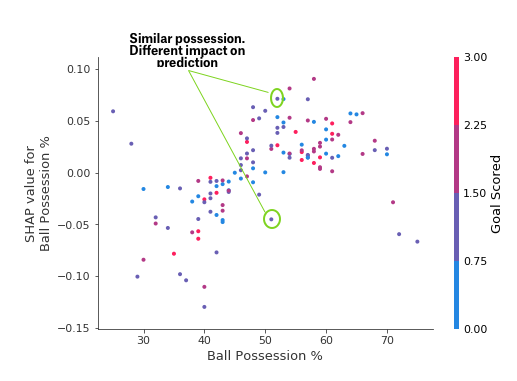

For comparison, a simple linear regression would produce plots that are perfect lines, without this spread.

This suggests we delve into the interactions, and the plots include color coding to help do that. While the primary trend is upward, you can visually inspect whether that varies by dot color.

Consider the following very narrow example for concreteness.
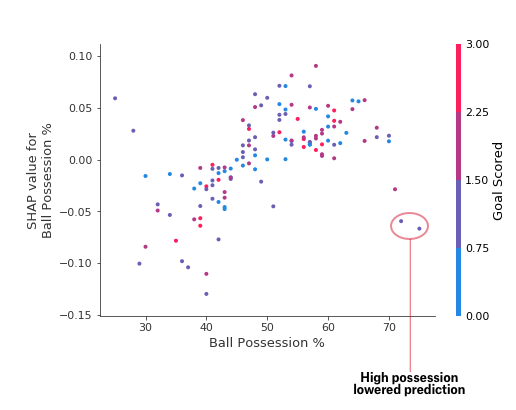

These two points stand out spatially as being far away from the upward trend. They are both colored purple, indicating the team scored one goal. You can interpret this to say In general, having the ball increases a team's chance of having their player win the award. But if they only score one goal, that trend reverses and the award judges may penalize them for having the ball so much if they score that little.

Outside of those few outliers, the interaction indicated by color isn't very dramatic here. But sometimes it will jump out at you.

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

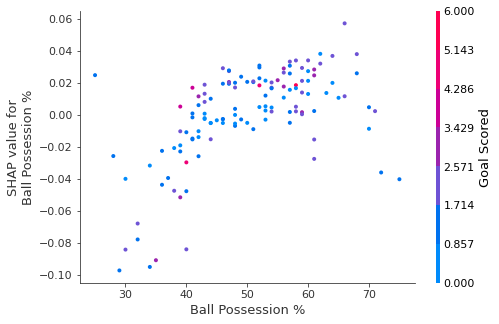

If you don't supply an argument for interaction_index, Shapley uses some logic to pick one that may be interesting.

This didn't require writing a lot of code. But the trick with these techniques is in thinking critically about the results rather than writing code itself.

the width of the range doesn't map well to any intuitive sense of "importance" because it can be determined by just a few outliers. However if all dots on the graph are widely spread from each other, that is a reasonable indication that permutation importance is high. Because the range of effects is so sensitive to outliers, permutation importance is a better measure of what's generally important to the model.

Is there an interaction between feature_of_interest and other_feature? If so, does feature_of_interest have a more positive impact on predictions when other_feature is high or when other_feature is low?

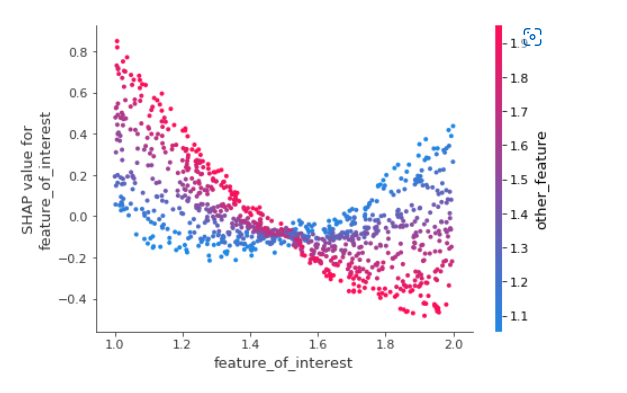

First, recall that the SHAP vaue is an estimate of the impact of a given feature on the prediction. So, if the dots trend from upper left to lower right, that means low values of feature_of_interest cause higher predictions.

Returning to this graph:

feature_of_interest slopes downward for high values of other_feature. To see this, focus your eye on the pink dots (where other_feature is high) and imagine a best-fit line through those pink dots. It slopes down, suggesting that the prediction goes down as feature_of_interest increases.

Now focus your eye on the blue dots, and imagine a best fit line through those dots. It is generally pretty flat, possibly even curving up on the right side of the graph. So increasing feature_of_interest has a more positive impact on predictions when other_feature is high.